In [175]:
import polars as pl
import numpy as np
from scipy.stats import norm

import requests
import json

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# CPI
U.S. Bureau of Labor Statistics – United States Department of Labor

https://beta.bls.gov/dataQuery

In [9]:
code_book = {
    'All items in U.S. city average, all urban consumers, seasonally adjusted': 'CUSR0000SA0',
    'Shelter in U.S. city average, all urban consumers, seasonally adjusted': 'CUSR0000SAH1',

    'West region, All items': 'CUUR0400SA0',
    'Los Angeles, All items': 'CUURS49ASA0',
    'San Francisco, All items': 'CUURS49BSA0',

    'Los Angeles-Long Beach-Anaheim': 'CUURS49ASA0',
    'Riverside-San Bernardino-Ontario': 'CUURS49CSA0',
    'San Diego-Carlsbad': 'CUURS49ESA0',
    'San Francisco-Oakland-Hayward': 'CUURS49BSA0',
}

In [10]:
headers = {'Content-type': 'application/json'}

series = [
    code_book['All items in U.S. city average, all urban consumers, seasonally adjusted'],
    code_book['Shelter in U.S. city average, all urban consumers, seasonally adjusted'],
]

data = json.dumps({"seriesid": series, "startyear":"2012", "endyear":"2023"})

p = requests.post('https://api.bls.gov/publicAPI/v1/timeseries/data/', data=data, headers=headers)

json_data = json.loads(p.text)

results = json_data['Results']['series']

In [11]:
[all_items, shelter] = results

In [12]:
df_shelter = pl.DataFrame([
    pl.Series('Year', [int(d['year']) for d in shelter['data']], pl.Int16),
    pl.Series('Month', [d['periodName'] for d in shelter['data']], pl.Utf8),
    pl.Series('CpiShelter', [float(d['value']) for d in shelter['data']], pl.Float32),
]).sort('Year')

df_all_items = pl.DataFrame([
    pl.Series('Year', [int(d['year']) for d in all_items['data']], pl.Int16),
    pl.Series('Month', [d['periodName'] for d in all_items['data']], pl.Utf8),
    pl.Series('CpiAll', [float(d['value']) for d in all_items['data']], pl.Float32),
]).sort('Year')

df_monthly_cpi = (
    df_all_items
    .join(
        df_shelter, 
        on=['Year', 'Month'], 
        how='inner'
    )
)

df_monthly_cpi.head()

Year,Month,CpiAll,CpiShelter
i16,str,f32,f32
2012,"""December""",231.220993,259.644012
2012,"""November""",231.248993,259.216003
2012,"""October""",231.638,258.81601
2012,"""September""",231.014999,258.233002
2012,"""August""",229.917999,257.647003


In [13]:
df_yearly_cpi = (
    df_monthly_cpi
    .groupby('Year')
    .agg([
        pl.col('CpiAll').mean().alias('CpiAllMean'),
        pl.col('CpiAll').std().alias('CpiAllStd'),
        pl.col('CpiShelter').mean().alias('CpiShelterMean'),
        pl.col('CpiShelter').std().alias('CpiShelterStd'),
    ])
    .sort('Year')
    .with_columns([
        (pl.col('CpiAllMean') - pl.col('CpiAllMean').shift(1)).alias('DiffMeanCpiAll'),
        (pl.col('CpiShelterMean') - pl.col('CpiShelterMean').shift(1)).alias('DiffMeanCpiShelter'),
    ])
)

df_yearly_cpi

Year,CpiAllMean,CpiAllStd,CpiShelterMean,CpiShelterStd,DiffMeanCpiAll,DiffMeanCpiShelter
i16,f32,f32,f32,f32,f32,f32
2012,229.586075,1.350803,257.080475,1.67952,null,null
2013,232.951736,0.969708,263.050323,1.931199,3.365662,5.969849
2014,236.715012,0.785505,270.509369,2.332262,3.763275,7.459045
2015,237.001755,1.145959,278.802063,2.664488,0.286743,8.292694
2016,240.005432,1.740881,288.233002,3.117234,3.003677,9.430939
2017,245.121017,1.498123,297.808685,2.853534,5.115585,9.575684
2018,251.098923,1.38294,307.661865,2.935363,5.977905,9.85318
2019,255.6465,1.761585,318.047852,3.039066,4.547577,10.385986
2020,258.838257,1.777962,325.89566,1.536052,3.191757,7.847809


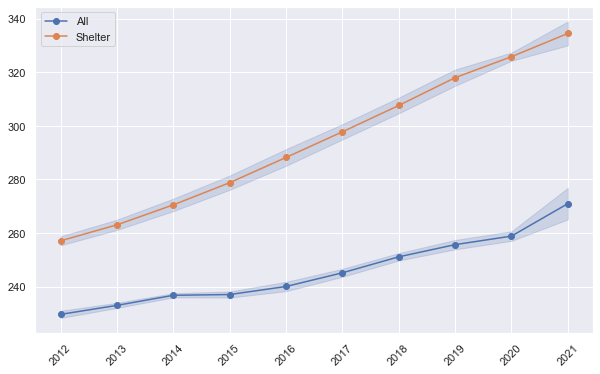

In [14]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(10, 6)

x = df_yearly_cpi['Year']
y_all = df_yearly_cpi['CpiAllMean']
std_all = df_yearly_cpi['CpiAllStd']
y_shelter = df_yearly_cpi['CpiShelterMean']
std_shelter = df_yearly_cpi['CpiShelterStd']

ax.plot(x, y_all, 'o', label='All', linestyle='-')
plt.fill_between(x, y_all - std_all, y_all + std_all, color='b', alpha=0.2)
ax.plot(x, y_shelter, 'o', label='Shelter', linestyle='-')
plt.fill_between(x, y_shelter - std_shelter, y_shelter + std_shelter, color='b', alpha=0.2)

ax.legend()
plt.xticks(x, rotation=45)
plt.show()

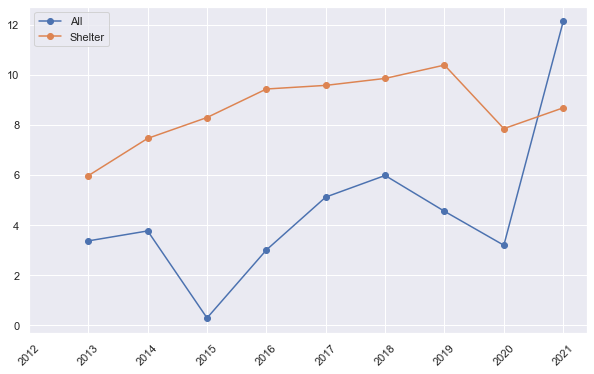

In [28]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(10, 6)

x = df_yearly_cpi['Year']
y_all = df_yearly_cpi['DiffMeanCpiAll']
y_shelter = df_yearly_cpi['DiffMeanCpiShelter']

ax.plot(x, y_all, 'o', label='All', linestyle='-')
ax.plot(x, y_shelter, 'o', label='Shelter', linestyle='-')

ax.legend()
plt.xticks(x, rotation=45)
plt.show()